In [1]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import math

In [2]:
COUNT = 10000
class Point:
    
    def normal(self, x):
        return math.e**(-(x-self._mu)**2/(2*self._sigma**2)) / (self._sigma*(2*math.pi)**0.5)

    


    def __init__(self, mu, sigma, size):
        self._mu    = mu
        self._sigma = sigma
        self._size  = size
        self.w = self._size/COUNT
        self._x = np.array(np.random.normal(self._mu,self._sigma, self._size))
        self._y = self.normal(self._x)
    
    def get_size(self):
        return self._size

    def get_x(self):
        return self._x

    def draw(self,_color = 'r.'):
        plt.plot(self._x,self._y, _color)
        # plt.hist(self._x, bins='auto', color='r', alpha = 0.35)
       
    

In [3]:
pt1 = Point(64,4,6000)
pt2 = Point(52,2,4000)


In [4]:
def proba_x(pt1:Point, pt2:Point):
    x = np.concatenate((pt1.get_x(), pt2.get_x()))
    proba_temp = []
    for i in x:
        P1_x = pt1.normal(i)
        P2_x = pt2.normal(i)
        P_x  = pt1.w * P1_x + pt2.w*P2_x

        P_x_1 = (pt1.w * P1_x)/P_x 
        P_x_2 = (pt2.w * P2_x)/P_x
        
        proba_temp.append([P_x_1, P_x_2])
        
    return np.array(proba_temp)


In [5]:
def predict(proba_x, limit = 0.5):
    pred_X = []
    for i in proba_x:
        if i[0]>=limit:
            pred_X.append(1)
        else:
            pred_X.append(2)
    return np.array(pred_X)

    

In [6]:
proba = proba_x(pt1,pt2)
pred = predict(proba)
pred

array([1, 1, 1, ..., 2, 2, 2])

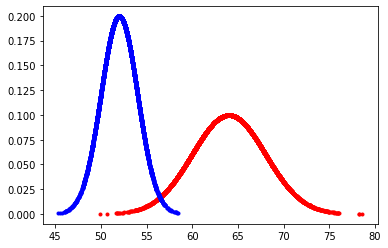

In [7]:
pt1.draw()
pt2.draw(_color='b.')


# Сгенерируем точки

In [8]:
k = 2       #количество признаков
N1 = 6000
N2 = 4000
N = N1+N2
m = 2       #количеств опризнаков

diametr1 = 64
mass1    = 14
sigma_d1  = 3.5
sigma_m1 = 1

diametr2 = 52
mass2    = 9.5
sigma_d2  = 2
sigma_m2 = 0.7
X = np.zeros((N1+N2, m))


In [9]:
X[:N1, 0] = np.random.normal(diametr1, sigma_d1, N1)
X[:N1, 1] = np.random.normal(mass1, sigma_m1, N1)

X[N1:N, 0] = np.random.normal(diametr2, sigma_d2, N2)
X[N1:N, 1] = np.random.normal(mass2, sigma_m2, N2)


Y = np.zeros((N))
Y[:N1] = 1
Y[N1:N] =2



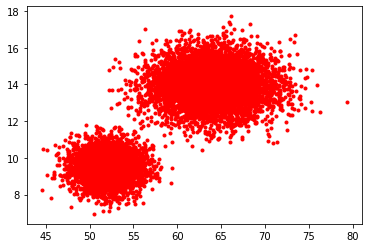

In [10]:
plt.plot(X[:N, 0], X[:N, 1], 'r.')

In [52]:
class EM:
    def __init__ (self,X:np.ndarray,N= 10000, k=2):
        self._N = N
        self._k = k
        self._X = X
        self._m = X.shape[1]
        self._n = X.shape[0]
        self._sigma = np.array(([1., 0.],[0., 1.], [1., 0.],[0., 1.]))
        self._sigma = self._sigma.reshape(k, self._m, self._m)
        self._w = np.array([float(1./k), float(1./k)])
        self._mu  = np.array((np.mean(self._X[np.random.choice(self._n, int(self._n/k))], axis = 0), np.mean(self._X[np.random.choice(self._n, int(self._n/k))], axis = 0)))

        # self._mu  = np.array([1,1])#np.array((np.mean(X[np.random.choice(self._n, self._n/k)], axis = 0), np.mean(X[np.random.choice(self._n, self._n/k)], axis = 0)))

    def e_step(self):
     
        pj_xi = []
        for j in range(self._k):
            det_sigma_j = np.linalg.det(self._sigma [j])
            factor_1 = 1 / (((2 * math.pi)**(self._k/2)) * ((det_sigma_j)**0.5))
            factor_2 = []
            for i in  self._X:
                factor_2.append(math.e**float(-0.5 * np.matrix(i - self._mu [j]) * np.matrix(np.linalg.inv(self._sigma [j])) * np.matrix(i - self._mu [j]).T))
            pj_xi.append(factor_1 * np.array(factor_2))
        pj_xi = np.array(pj_xi)
        
        
        pj_xi_w = []
        for j in range(self._k):
            pj_xi_w.append(pj_xi[j] * self._w[j])
        pj_xi_w = np.array(pj_xi_w)
        # print("dcd = ",pj_xi_w)
        
        sum_pj_xi_w = np.sum(pj_xi_w, axis = 0)
        
        
        proba_xi = []
        for j in range(self._k):
            proba_xi.append(pj_xi_w[j]/ sum_pj_xi_w)
            # print(f"1 = {pj_xi_w[j]} 2 = {sum_pj_xi_w} 3 = {pj_xi_w[j]/ sum_pj_xi_w}")
        
        return np.array(proba_xi)

    def x_new(self, proba_xi):
        X1_new_ind = []
        X2_new_ind = []
        X_answers = []

        count = 0
        for x in proba_xi[0]:
            if x >= 0.5:
                X1_new_ind.append(count)
                X_answers.append(1)
            else:
                X2_new_ind.append(count)
                X_answers.append(2)
            count += 1
        
        return X1_new_ind, X2_new_ind, X_answers


    def m_step(self, proba_xi):
        w_new = np.sum(proba_xi, axis = 1) / self._N 
        
        print(w_new)
        
        mu_new = (np.array((np.matrix(proba_xi) * np.matrix(self._X))).T / np.sum(proba_xi, axis = 1)).T
        
        # рассчитаем дисперсии
        cov_new = []
        for mu in range(mu_new.shape[0]):
            X_cd = []
            X_cd_proba = []
            count = 0
            for x_i in  self._X:
                cd = np.array(x_i - mu_new[mu])
                X_cd.append(cd)
                X_cd_proba.append(cd * proba_xi[mu][count])
                count += 1
            X_cd = np.array(X_cd)
            X_cd = X_cd.reshape(self._N , self._m)
            X_cd_proba = np.array(X_cd_proba)
            X_cd_proba = X_cd_proba.reshape(self._N , self._m)

            cov_new.append(np.matrix(X_cd.T) * np.matrix(X_cd_proba))
        cov_new = np.array((np.array(cov_new) / (np.sum(proba_xi, axis = 1)-1)))
       
        if cov_new[0][0][1] < 0:
            cov_new[0][0][1] = 0
        if cov_new[0][1][0] < 0:
            cov_new[0][1][0] = 0
        
        if cov_new[1][0][1] < 0:
            cov_new[1][0][1] = 0
        if cov_new[1][1][0] < 0:
            cov_new[1][1][0] = 0
        
        # рассчитаем стандартное отклонение
        sigma_new = cov_new**0.5
        return w_new, mu_new, sigma_new


    def fit(self, c_iteration):
        for i in range(c_iteration):
            proba_xi = self.e_step()
       
            self._w, self._mu, self._sigma = self.m_step(proba_xi)
            X1_new_ind, X2_new_ind, X_answers = self.x_new(proba_xi)
            print('Итерация №', i+1)
            
            print('Матрица значений математических ожиданий')
            print(self._mu)

            print('Матрица значений стандартных отклонений')
            print(self._sigma)
            
            # print('Доля правильно распознанных изделий')
            # print(round(accuracy_score(y, X_answers),3))
            
        plt.figure(figsize=(16, 6))  
        plt.plot(
            self._X[X1_new_ind,0], X[X1_new_ind,1], 'o', alpha = 0.7, color='sandybrown', label = 'Produced on machine #1')
        plt.plot(
            self._X[X2_new_ind,0], X[X2_new_ind,1], 'o', alpha = 0.45, color = 'darkblue', label = 'Produced on machine #2')
        plt.plot(self._mu[0][0], self._mu[0][1], 'o', markersize = 16, color = 'r', label = 'Mu 1')
        plt.plot(self._mu[1][0], self._mu[1][1], 'o',  markersize = 16, color = 'b', label = 'Mu 2')
        plt.xlabel('Diameter')
        plt.ylabel('Weight')
        plt.legend()
        plt.show()


[0.50040355 0.49959645]
Итерация № 1
Матрица значений математических ожиданий
[[58.24658454 11.96502797]
 [60.16839509 12.45253757]]
Матрица значений стандартных отклонений
[[[6.53598075 3.64234665]
  [3.63940748 2.42125139]]

 [[6.54616233 3.52507775]
  [3.52223321 2.32096166]]]
[0.5214911 0.4785089]
Итерация № 2
Матрица значений математических ожиданий
[[54.37913797 11.03379396]
 [64.46792894 13.48890414]]
Матрица значений стандартных отклонений
[[[4.47753749 3.17782231]
  [3.0440195  2.48504969]]

 [[3.88834109 2.07288219]
  [1.98560309 1.59684666]]]
[0.49660867 0.50339133]
Итерация № 3
Матрица значений математических ожиданий
[[53.45893623 10.61256468]
 [64.87704703 13.78310268]]
Матрица значений стандартных отклонений
[[[3.59076747 2.53467425]
  [2.55192827 2.16832239]]

 [[3.09020809 1.24834691]
  [1.25684465 1.26010981]]]
[0.46588586 0.53411414]
Итерация № 4
Матрица значений математических ожиданий
[[52.91562958 10.29974398]
 [64.69416939 13.87359067]]
Матрица значений стандартн

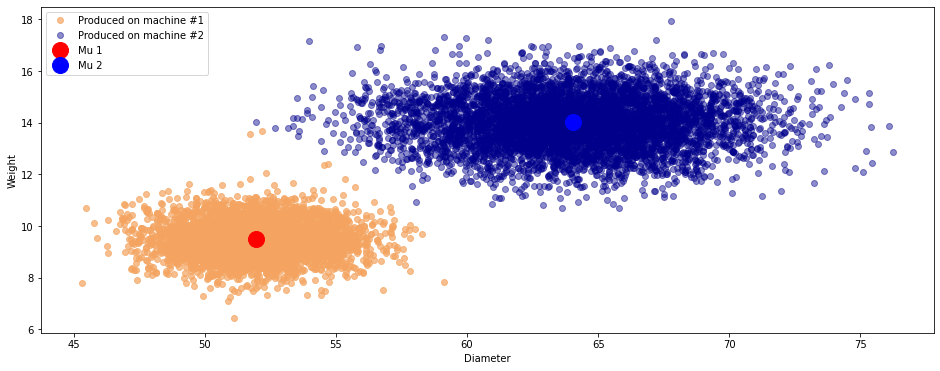

In [53]:

    
model = EM(X, 10000)
model.fit(15)

In [21]:
from sklearn.mixture import GaussianMixture

In [53]:
model_em = GaussianMixture(n_components=2, covariance_type="full")
model_em.fit(X)

some_detail = np.array([[55, 9]]) # диаметр и масса
classifire_data = model_em.predict(some_detail)
print(f"Класс - {classifire_data}")


Класс - [1]


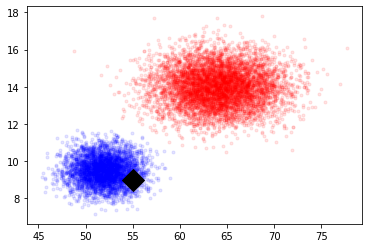

In [59]:
plt.plot(X[:N1,0], X[:N1,1], "r.", alpha = 0.1)
plt.plot(X[N1:N,0], X[N1:N,1], "b.", alpha = 0.1)
plt.plot(some_detail[0,0], some_detail[0,1], "Dk", markersize = 15)

array([[63.39108749, 14.05863807],
       [70.87378926, 13.63871105],
       [60.60953382, 12.91112347],
       ...,
       [53.45215546,  9.57598512],
       [49.97344784, 10.27380942],
       [54.30533019,  8.56945275]])